In [24]:
# Импортируем numpy для хранения результатов расчётов
import numpy as np

# Импортируем модуль matplolib для визуализации результатов
import matplotlib.pyplot as plt

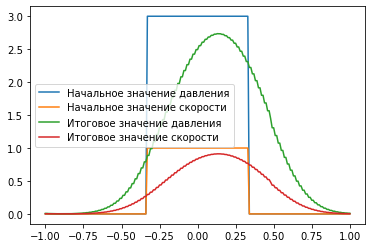

In [25]:
# С МОНОТОНИЗАЦИЕЙ

# Определим параметры 1D акустической задачи
L = 2.0 # x = [-1,1]
rho = 3.0 # плотность в кг/м^3
c = 1.0 # скорость волны в м/с
T = 1.0 * L / c # 1 полный оборот начального возмущения
M = 201 # количество узлов вдоль оси
h = L / M # шаг по координате, h
dt = 0.4 * h / c # коэффициент должен быть меньше единицы
# В каждом узле мы храним значение давления и скорости среды
data_current = np.zeros(M, dtype=[('v', np.float64), ('p', np.float64)])
data_next = np.zeros(M, dtype=[('v', np.float64), ('p', np.float64)])

# Определим теперь функции, которые на основании Omega и Omega^(-1) умеют нам возвращать трансформированный вектор
def Omega(q):
    v, p = q
    return (-rho * c / 2.0 * v + p / 2.0, rho * c / 2.0 * v + p / 2.0)

def OmegaInv(w1, w2):
    return (- w1 / (rho * c) + w2 / (rho * c), w1 + w2)

# Начальные значения в виде продольной волны
for i in range(int(1.0 / 3.0 * M), int(2.0 / 3.0 * M)):
    data_current[i]['v'] = 1.0
    data_current[i]['p'] = rho * c * data_current[i]['v'] # -rho * c / 2 * V + P / 2 = 0

# Рисуем график до начала расчёта
x_m = np.linspace(-1.0, L - 1.0, M)
plt.plot(x_m, data_current['p'], label="Начальное значение давления")
plt.plot(x_m, data_current['v'], label="Начальное значение скорости")

for j in range(int(T / dt)):
    for i in range(M):
        # w1 for -c, w2 for +c
        # Переходим в инварианты Римана
        w1, w2   = Omega(data_current[i])
        # p - слева, n - справа
        if i == 0: # Левая граница области
            w1p, w2p = Omega(data_current[M - 1])
            w1n, w2n = Omega(data_current[i + 1])
        elif i == M - 1: # Правая граница области
            w1n, w2n = Omega(data_current[0])
            w1p, w2p = Omega(data_current[i - 1])
        else: # Внутри области
            w1p, w2p = Omega(data_current[i - 1])
            w1n, w2n = Omega(data_current[i + 1])
        # Решаем уравнения переноса на инварианты (правильно-сторонний шаблон)
        a1 = (w1n + w1p - 2 * w1) / (2 * h ** 2)
        b1 = (w1n - w1p) / (2 * h)
        c1 = w1
        a2 = (w2n + w2p - 2 * w2) / (2 * h ** 2)
        b2 = (w2n - w2p) / (2 * h)
        c2 = w2
        k = c * dt
        t1 = a1 * k ** 2 + b1 * k + c1
        t2 = a2 * k ** 2 + b2 * k + c2
        # Монотонизация
        if i == 0:
            min_v = min(data_current[M - 1]['v'], data_current[i + 1]['v'])
            min_p = min(data_current[M - 1]['p'], data_current[i + 1]['p'])
            max_v = max(data_current[M - 1]['v'], data_current[i + 1]['v'])
            max_p = max(data_current[M - 1]['p'], data_current[i + 1]['p'])
        elif i == M - 1:
            min_v = min(data_current[i - 1]['v'], data_current[0]['v'])
            min_p = min(data_current[i - 1]['p'], data_current[0]['p'])
            max_v = max(data_current[i - 1]['v'], data_current[0]['v'])
            max_p = max(data_current[i - 1]['p'], data_current[0]['p'])
        else:
            min_v = min(data_current[i - 1]['v'], data_current[i + 1]['v'])
            min_p = min(data_current[i - 1]['p'], data_current[i + 1]['p'])
            max_v = max(data_current[i - 1]['v'], data_current[i + 1]['v'])
            max_p = max(data_current[i - 1]['p'], data_current[i + 1]['p'])
        
        if t1 < min_v:
            t1 = min_v
        elif t1 > max_v:
            t1 = max_v
        else:
            w1_new = t1
        
        if t2 < min_p:
            t2 = min_p
        elif t2 > max_p:
            t2 = max_p
        else:
            w2_new = t2
            
        # Возвращаемся в исходные переменные
        data_next[i]['v'], data_next[i]['p'] = OmegaInv(w1_new, w2_new)
    # Обновляем весь слой
    for i in range(M):
        data_current[i] = data_next[i]
        
# Рисуем график по окончанию расчёта
plt.plot(x_m, data_current['p'], label="Итоговое значение давления")
plt.plot(x_m, data_current['v'], label="Итоговое значение скорости")
plt.legend()
plt.show()

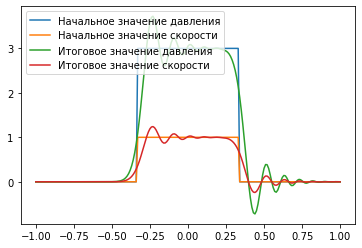

In [26]:
# БЕЗ МОНОТОНИЗАЦИИ

# Определим параметры 1D акустической задачи
L = 2.0 # x = [-1,1]
rho = 3.0 # плотность в кг/м^3
c = 1.0 # скорость волны в м/с
T = 1.0 * L / c # 1 полный оборот начального возмущения
M = 201 # количество узлов вдоль оси
h = L / M # шаг по координате, h
dt = 0.4 * h / c # коэффициент должен быть меньше единицы
# В каждом узле мы храним значение давления и скорости среды
data_current = np.zeros(M, dtype=[('v', np.float64), ('p', np.float64)])
data_next = np.zeros(M, dtype=[('v', np.float64), ('p', np.float64)])

# Определим теперь функции, которые на основании Omega и Omega^(-1) умеют нам возвращать трансформированный вектор
def Omega(q):
    v, p = q
    return (-rho * c / 2.0 * v + p / 2.0, rho * c / 2.0 * v + p / 2.0)

def OmegaInv(w1, w2):
    return (- w1 / (rho * c) + w2 / (rho * c), w1 + w2)

# Начальные значения в виде продольной волны
for i in range(int(1.0 / 3.0 * M), int(2.0 / 3.0 * M)):
    data_current[i]['v'] = 1.0
    data_current[i]['p'] = rho * c * data_current[i]['v'] # -rho * c / 2 * V + P / 2 = 0

# Рисуем график до начала расчёта
x_m = np.linspace(-1.0, L - 1.0, M)
plt.plot(x_m, data_current['p'], label="Начальное значение давления")
plt.plot(x_m, data_current['v'], label="Начальное значение скорости")
for j in range(int(T / dt)):
    for i in range(M):
        # w1 for -c, w2 for +c
        # Переходим в инварианты Римана
        w1, w2   = Omega(data_current[i])
        # p - слева, n - справа
        if i == 0: # Левая граница области
            w1p, w2p = Omega(data_current[M - 1])
            w1n, w2n = Omega(data_current[i + 1])
        elif i == M - 1: # Правая граница области
            w1n, w2n = Omega(data_current[0])
            w1p, w2p = Omega(data_current[i - 1])
        else: # Внутри области
            w1p, w2p = Omega(data_current[i - 1])
            w1n, w2n = Omega(data_current[i + 1])
        # Решаем уравнения переноса на инварианты (правильно-сторонний шаблон)
        a1 = (w1n + w1p - 2 * w1) / (2 * h ** 2)
        b1 = (w1n - w1p) / (2 * h)
        c1 = w1
        a2 = (w2n + w2p - 2 * w2) / (2 * h ** 2)
        b2 = (w2n - w2p) / (2 * h)
        c2 = w2
        k = c * dt
        w1_new = a1 * k ** 2 + b1 * k + c1
        w2_new = a2 * k ** 2 + b2 * k + c2
            
        # Возвращаемся в исходные переменные
        data_next[i]['v'], data_next[i]['p'] = OmegaInv(w1_new, w2_new)
    # Обновляем весь слой
    for i in range(M):
        data_current[i] = data_next[i]
        
# Рисуем график по окончанию расчёта
plt.plot(x_m, data_current['p'], label = "Итоговое значение давления")
plt.plot(x_m, data_current['v'], label = "Итоговое значение скорости")
plt.legend()
plt.show()